
# Bayesian Analysis for Tritium Binding Energy with TRIMOD


In [29]:
from __future__ import annotations
from pathlib import Path
import re
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd

# regex per estrarre la riga corrispodente all'energia di legame
_RE_E = re.compile(r"3-body binding energy\s*=\s*([-+]?[\d.]+(?:[eE][-+]?\d+)?)\s*MeV")

def write_params(theta, workdir="."):
    """
    theta = (v01, v02, a1, a2)
    scrive params.in come UNA riga: v01 v02 a1 a2
    """
    v01, v02, a1, a2 = theta
    Path(workdir, "params.in").write_text(f"{v01} {v02} {a1} {a2}\n", encoding="utf-8")


def run_trimod(exe: str | Path = "./trimod.x", workdir: str | Path | None = None) -> float:
    """
    lancia l'eseguibile Fortran (trimod) e restituisce la 3-body binding energy in MeV.
    - exe: path dell'eseguibile (./trimod.x oppure ./run)
    - workdir: directory di lavoro dove si trova output.dat (default: cartella dell'eseguibile)
    """
    exe = Path(exe).resolve()
    if not exe.exists():
        raise FileNotFoundError(f"Eseguibile non trovato: {exe}")

    wd = Path(workdir) if workdir else exe.parent
    wd = wd.resolve()
    if not wd.exists():
        raise FileNotFoundError(f"Working directory non trovata: {wd}")

    # lancia il programma Fortran nella sua cartella
    subprocess.run([str(exe)], cwd=wd, check=True)

    # Legge il file di output
    out = (wd / "output.dat").read_text(encoding="utf-8")

    # Estrae l'energia
    m = _RE_E.search(out)
    if not m:
        raise RuntimeError("Non ho trovato la riga con '3-body binding energy' in output.dat")
    return float(m.group(1))



## 1. Bayesian model

We infer \(\theta = (v_{01}, v_{02}, a_1, a_2)\) from the triton binding energy \(E_3\).
- **Prior**: uniform within broad physical bounds.
- **Likelihood**: Gaussian comparing model \(E_3(\theta)\) vs. experimental value.  
  We include a theoretical error \(\sigma_\text{th}\) added in quadrature to the experimental \(\sigma_\text{exp}\).

You can tighten these ranges or replace with physics-informed priors later.


In [ ]:
# Dato “target” 
E3_EXP    = -8.482   # MeV, trizio reale (o altro target)
SIGMA_TH  = 0.5      # MeV, incertezza teorica (tuning)
SIGMA_EXP = 0.001    # MeV, sperimentale (qui quasi trascurabile)

def logprior(theta):
    """
    Prior uniforme (box) su un range ragionevole.
    theta = (v01, v02, a1, a2)
    """
    v01, v02, a1, a2 = theta
    if not (-1500 < v01 <   0): return -np.inf
    if not (    0 < v02 < 5000): return -np.inf
    if not (  0.5 <  a1 <  3.5): return -np.inf
    if not (  1.0 <  a2 <  6.0): return -np.inf
    return 0.0

def loglike(theta, exe=TRIMOD_EXE, workdir=WORKDIR):
    """
    Likelihood gaussiana sull’energia E3.
    1) scrivo params.in
    2) lancio trimod
    3) valuto N(E3 | E3_exp, sigma)
    """
    # Scrive params.in nello stesso workdir di TRIMOD
    write_params(theta, workdir)
    # Esegue TRIMOD e legge E3 da output.dat
    E3 = run_trimod(exe=exe, workdir=workdir)
    sigma = np.hypot(SIGMA_TH, SIGMA_EXP)
    r = (E3 - E3_EXP)/sigma
    return -0.5*r*r - np.log(sigma*np.sqrt(2*np.pi))

def logposterior(theta, exe=TRIMOD_EXE, workdir=WORKDIR):
    """
    Posterior = prior + likelihood, con robustezza agli errori di run.
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    try:
        ll = loglike(theta, exe=exe, workdir=workdir)
        return lp + ll
    except Exception as e:
        # Se TRIMOD non converge o fallisce, assegniamo prob. ~0
        # (in alternativa, puoi loggare l’eccezione)
        # print("[logposterior] eccezione:", e)
        return -np.inf


In [33]:
# Punto di riferimento (gli altri 3 parametri fissi)
theta_ref = (-570.316, 1438.4812, 1.55, 3.11)

grid_v01 = np.linspace(-700.0, -500.0, 9)  # 9 punti
rows = []

for v01 in grid_v01:
    theta = (float(v01), theta_ref[1], theta_ref[2], theta_ref[3])
    lp = logprior(theta)
    if not np.isfinite(lp):
        rows.append({"v01": v01, "E3": np.nan, "logpost": -np.inf})
        continue
    try:
        write_params(theta, WORKDIR)
        E3 = run_trimod(exe=TRIMOD_EXE, workdir=WORKDIR)
        sigma = np.hypot(SIGMA_TH, SIGMA_EXP)
        r = (E3 - E3_EXP)/sigma
        loglike = -0.5*r*r - np.log(sigma*np.sqrt(2*np.pi))
        logpost = lp + loglike
        rows.append({"v01": v01, "E3": E3, "logpost": logpost})
    except Exception as e:
        rows.append({"v01": v01, "E3": np.nan, "logpost": -np.inf})

df = pd.DataFrame(rows)
display(df)


 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Too many iterations in the main loop
 Parameter ie exceeded the value iemax
 Parameter iter exceeded the value itermax
 Parameter iter exceeded the value itermax


,v01,E3,logpost
0,-700.0,NaN,-inf
1,-675.0,NaN,-inf
2,-650.0,NaN,-inf
3,-625.0,NaN,-inf
4,-600.0,NaN,-inf
5,-575.0,NaN,-inf
6,-550.0,NaN,-inf
7,-525.0,NaN,-inf
8,-500.0,NaN,-inf


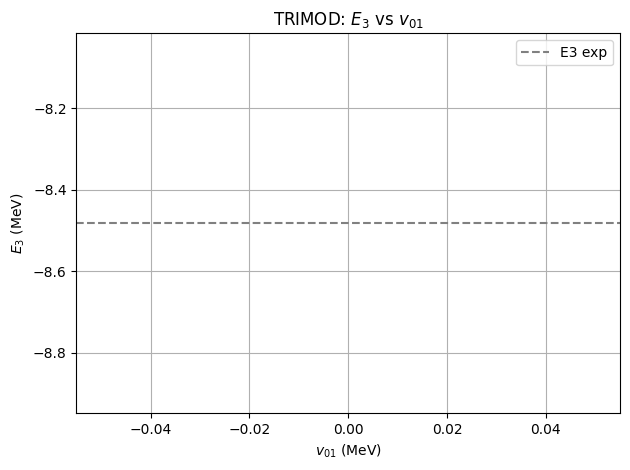

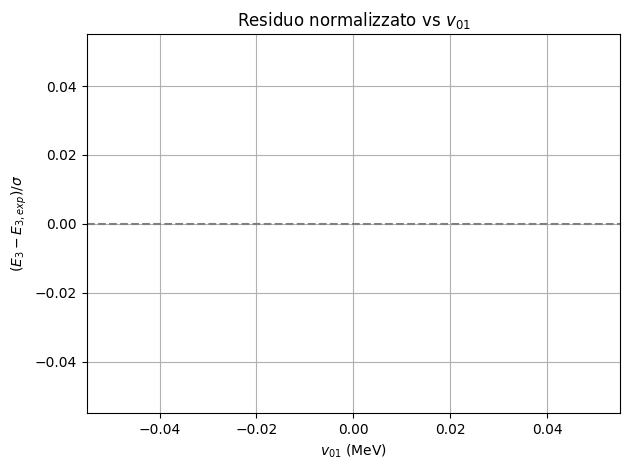

In [ ]:
# E3 vs v01
plt.figure()
plt.plot(df["v01"], df["E3"], marker="o")
plt.axhline(E3_EXP, color="gray", linestyle="--", label="E3 exp")
plt.xlabel(r"$v_{01}$ (MeV)")
plt.ylabel(r"$E_3$ (MeV)")
plt.title("TRIMOD: $E_3$ vs $v_{01}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuo normalizzato vs v01
sigma = np.hypot(SIGMA_TH, SIGMA_EXP)
resid = (df["E3"] - E3_EXP)/sigma
plt.figure()
plt.plot(df["v01"], resid, marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel(r"$v_{01}$ (MeV)")
plt.ylabel(r"$(E_3 - E_{3,exp})/\sigma$")
plt.title("Residuo normalizzato vs $v_{01}$")
plt.grid(True)
plt.tight_layout()
plt.show()
